In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Initvalues

In [3]:
input_window = 40 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
block_len = input_window + output_window # for one input-output pair
batch_size = 10
train_size = 0.8
modelDim = 250
device = "cuda"

# Create toy dataset
noisy sin

4000


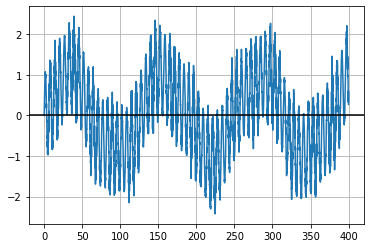

In [4]:
# construct a littel toy dataset
time        = np.arange(0, 400, 0.1)    
amplitude   = np.sin(time) + np.sin(time * 0.05) + \
                np.sin(time * 0.12) * np.random.normal(-0.2, 0.2, len(time))
print(len(amplitude))
plt.plot(time,amplitude)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')

# Split Test Train

In [5]:
sampels = int(len(time) * train_size) # use a parameter to control training size
train_data = amplitude[:sampels]
test_data = amplitude[sampels:]
print(len(train_data), len(test_data))

3200 800


# Create sequence
len of input_data split -> train|test

minus the window_size 

create and Tensor with the dimensions of (L, 2, input_window)

eg: [1-3100 1-3100..., 1-3100 1-3100...] times 100


In [6]:
def create_inout_sequences(input_data, input_window ,output_window):
    inout_seq = []
    L = len(input_data)
    block_num =  L - block_len + 1

    # total of [N - block_len + 1] blocks
    # where block_len = input_window + output_window

    for i in range( block_num ):
        train_seq = input_data[i : i + input_window]
        train_label = input_data[i + output_window : i + input_window + output_window]
        inout_seq.append((train_seq ,train_label))

    return torch.FloatTensor(np.array(inout_seq)) # creates a tensor [L,2,input_window]

train_sequence = create_inout_sequences( train_data,input_window ,output_window)

test_sequence = create_inout_sequences(test_data,input_window,output_window)
print("Train_Tensor size: ", train_sequence.size())
print("Test_Tensor size: ",test_sequence.size())

Train_Tensor size:  torch.Size([3160, 2, 40])
Test_Tensor size:  torch.Size([760, 2, 40])


# Create Class PositionEncoding
even pos = $sin(x * \frac{1}{\frac{1000^{2*dmodel}}{dmodel}})$

odd pos = $cos(x * \frac{1}{\frac{1000^{2*dmodel}}{dmodel}})$

output a tensor 

In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()     
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        # )
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        #pe.requires_grad = False
        self.register_buffer('pe', pe)
        print("PositionalEncoding outputSize: ",pe.size())

    def forward(self, x):
        # print(self.pe[:x.size(0), :].repeat(1,x.shape[1],1).shape ,'---',x.shape)
        # dimension 1 maybe inequal batchsize
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)
    
pos_encoder = PositionalEncoding(modelDim)

PositionalEncoding outputSize:  torch.Size([5000, 1, 250])


In [8]:
class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(1,feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            mask = self._generate_square_subsequent_mask(len(src))
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [9]:
def get_batch(input_data, i , batch_size):

    # batch_len = min(batch_size, len(input_data) - 1 - i) #  # Now len-1 is not necessary
    batch_len = min(batch_size, len(input_data) - i)
    data = input_data[ i:i + batch_len ]
    input = torch.stack([item[0] for item in data]).view((input_window,batch_len,1))
    # ( seq_len, batch, 1 ) , 1 is feature size
    target = torch.stack([item[1] for item in data]).view((input_window,batch_len,1))
    return input, target

In [10]:
def train(train_data,model,optimizer, criterion,epoch,scheduler):
    model.train() # Turn on the train mode \o/
    total_loss = 0.
    #start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data), batch_size)):  # Now len-1 is not necessary
        # data and target are the same shape with (input_window,batch_len,1)
        data, targets = get_batch(train_data, i , batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            #elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                   'ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            #start_time = time.time()
    return model

In [11]:
# predict the next n steps based on the input data 
def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, _ = get_batch(data_source , 0 , 1)
    with torch.no_grad():
        for i in range(0, steps):            
            output = eval_model(data[-input_window:])
            # (seq-len , batch-size , features-num)
            # input : [ m,m+1,...,m+n ] -> [m+1,...,m+n+1]
            data = torch.cat((data, output[-1:])) # [m,m+1,..., m+n+1]


    print("R2: ",r2_score)
    data = data.cpu().view(-1)

In [12]:
def plot_and_loss(eval_model, data_source,epoch,criterion):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        # for i in range(0, len(data_source) - 1):
        for i in range(len(data_source)):  # Now len-1 is not necessary
            data, target = get_batch(data_source, i , 1) # one-step forecast
            output = eval_model(data)            
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy() -> no need to detach stuff.. 
    len(test_result)
    print("R2 Score: ", r2_score(test_result,truth))

    return test_result, truth

In [13]:
model = TransAm(feature_size = modelDim)
criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 1 # The number of epochs
best_model = None

PositionalEncoding outputSize:  torch.Size([5000, 1, 250])


/home/alexander/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |    63/  316 batches | lr 0.005000 |  6.37 ms | ppl   583.87
| epoch   1 |   126/  316 batches | lr 0.005000 |  0.53 ms | ppl     1.70
| epoch   1 |   189/  316 batches | lr 0.005000 |  0.25 ms | ppl     1.28
| epoch   1 |   252/  316 batches | lr 0.005000 |  0.18 ms | ppl     1.20
| epoch   1 |   315/  316 batches | lr 0.005000 |  0.19 ms | ppl     1.21
R2 Score:  0.37193729914023754


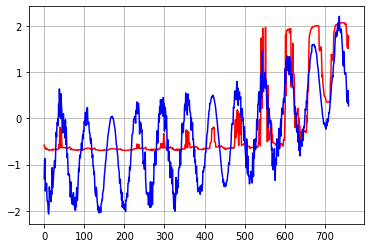

In [14]:
for epoch in range(1, epochs + 1):
    model = train(train_sequence,model,optimizer, criterion,epoch,scheduler)
    #predict_future(model, test_sequence,200)
    test_result, truth = plot_and_loss(model, test_sequence,epoch,criterion)

    scheduler.step() 
plt.plot(test_result,color="red")
plt.plot(truth,color="blue")
plt.grid()

# Building data 

In [15]:
import pandas as pd

In [22]:
data = pd.read_csv("data/Office_Eddie.csv")
data = data.dropna()
data = data.drop("Unnamed: 0",axis=1)
print(data)

      TemperatureC  Dew PointC   Humidity  Sea Level PressurehPa  \
0         8.300000    2.200000  66.000000            1018.300000   
1         7.800000    2.200000  68.000000            1018.500000   
2         6.100000    1.700000  74.000000            1018.700000   
3         3.900000    1.100000  82.000000            1019.100000   
5         1.700000    0.600000  92.000000            1019.600000   
...            ...         ...        ...                    ...   
7261     13.633333   12.066667  90.333333             970.800000   
7262     14.333333   13.000000  92.000000             967.366667   
7263     15.720000   13.980000  89.600000             962.440000   
7264     16.100000   14.400000  90.000000             958.100000   
7265     16.925000   15.000000  88.500000             980.375000   

      VisibilityKm  WindDirDegrees  energyConsumption  \
0        16.100000      280.000000           24.92155   
1        16.100000      290.000000           24.75485   
2        16.

In [23]:
sampels = int(len(data) * train_size) # use a parameter to control training size
train_data = data["energyConsumption"][:sampels]
test_data = data["energyConsumption"][sampels:]
print(len(train_data), len(test_data))

5234 1309


In [24]:
train_sequence = create_inout_sequences( train_data,input_window ,output_window)

test_sequence = create_inout_sequences(test_data,input_window,output_window)

PositionalEncoding outputSize:  torch.Size([5000, 1, 250])


/home/alexander/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |   103/  519 batches | lr 0.005000 | 215.13 ms | ppl 2679306588245255235523595262884462061048267082322620204319190522298137193736688913571142172672.00
| epoch   1 |   206/  519 batches | lr 0.005000 | 184.58 ms | ppl 145503576794351048526880406532195075057754990308320876706573497435419647756206080.00
| epoch   1 |   309/  519 batches | lr 0.005000 | 209.53 ms | ppl 9959346777500166359884835083668734142669606704649913325421188088471423407131562072657100800.00
| epoch   1 |   412/  519 batches | lr 0.005000 | 252.42 ms | ppl 42327275402315944968982785413910380385176400580153685406795466311718983729470780838645669557452689591356096512.00
| epoch   1 |   515/  519 batches | lr 0.005000 | 262.59 ms | ppl 1105371210493792877253206271342587737541336279051358629566486131928598346795253039726974867312936808666966039461888.00
R2 Score:  -31252305814.98118


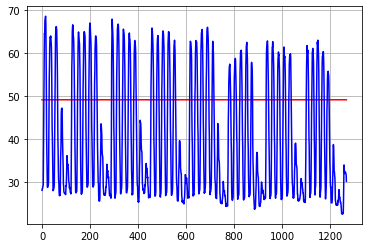

In [25]:
model = TransAm(feature_size = modelDim)
criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

best_val_loss = float("inf")
epochs = 1 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    model = train(train_sequence,model,optimizer, criterion,epoch,scheduler)
    #predict_future(model, test_sequence,200)
    test_result, truth = plot_and_loss(model, test_sequence,epoch,criterion)

    scheduler.step() 
plt.plot(test_result,color="red")
plt.plot(truth,color="blue")
plt.grid()